In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns

import PaSDqc

In [2]:
def fit_curve(freq, nd):
    l_params = []
    freq_cut = freq[freq < 1e-3]
    freq_cut_scale = -np.log10(freq_cut)
    
    for psd in nd:
        ampl = PaSDqc.amplicon.AmplDist(freq, psd)
        ampl.fit_curve(method='erf')
        l_params.append(ampl.popt['erf'])
        
    return l_params

In [3]:
def gaussian2(l_params, freq_eval):
    l_pdf = []
    for p in l_params:
        pdf = scipy.stats.norm(loc=p[2], scale=p[3])
        l_pdf.append(pdf.pdf(freq_eval))
        
    return l_pdf

In [4]:
norm = PaSDqc.extra_tools.load_bulk_psd()

### Data analysis

Perform clustering

In [5]:
freq, nd, sample_list = PaSDqc.extra_tools.mk_ndarray("../data/cluster/")
link = PaSDqc.extra_tools.hclust(nd, method='ward')

Curve fitting

In [6]:
lp_bad = fit_curve(freq, nd[3:])
lp_good = fit_curve(freq, nd[:3])

Amplicon size density estimation

In [7]:
freq_eval = np.arange(3, 5.5, 0.01)
l_pdf_good = gaussian2(lp_good, freq_eval)

freq_eval2 = np.arange(2.5, 5.5, 0.01)
l_pdf_bad = gaussian2(lp_bad, freq_eval2)

### Plot

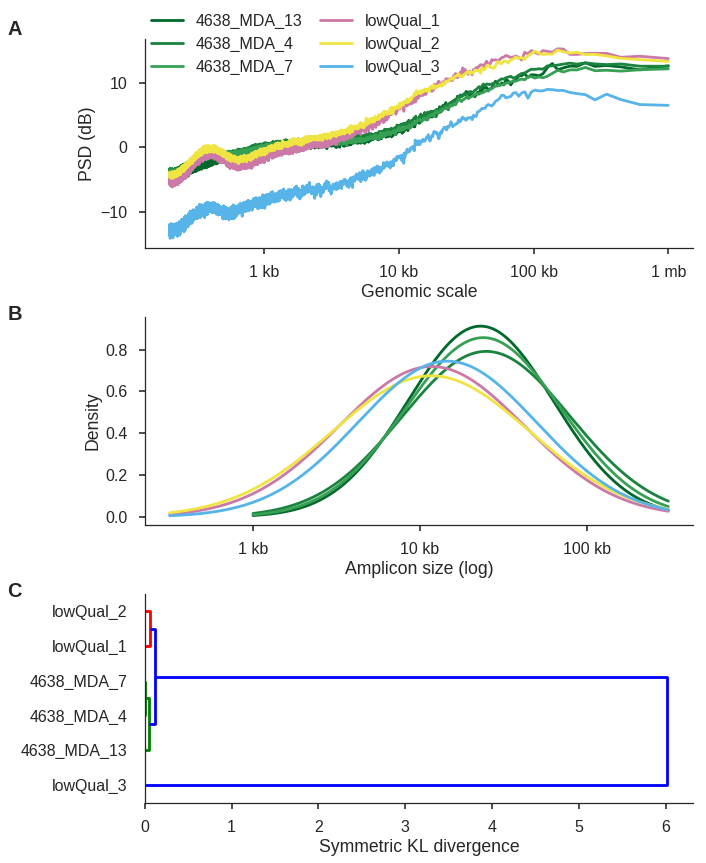

In [8]:
sns.set_context('poster')
sns.set_style("ticks", {'ytick.minor.size': 0.0, 'xtick.minor.size': 0.0})
sns.set_palette('colorblind')

cp = sns.color_palette()
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))


for avg, s, c in zip(nd[:3], sample_list[:3], sns.color_palette("Greens_r", 8)):
    ax[0].plot(1/freq, 10*np.log10(avg/norm), label=s, color=c)

for pdf, s ,c in zip(l_pdf_good, sample_list[:3], sns.color_palette("Greens_r", 8)):
    ax[1].plot(10**freq_eval, pdf, color=c, label=s)

for avg, s, c in zip(nd[3:], sample_list[3:], cp[3:]):
     ax[0].plot(1/freq, 10*np.log10(avg/norm), label=s, color=c)

cp = sns.color_palette()
for pdf, s, c in zip(l_pdf_bad, sample_list[3:], cp[3:]):
     ax[1].plot(10**freq_eval2, pdf, label=s, color=c)
    
ax[1].set_xscale('log')
ax[1].set_xlabel('Amplicon size (log)')
ax[1].set_ylabel('Density')
ax[1].set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

ax[0].set_xlabel('Genomic scale')
ax[0].legend(bbox_to_anchor=(0., 0.8, 0.55, .102), loc=(0, 0), ncol=2, mode="expand", borderaxespad=0.)
ax[0].set_xscale('log')
ax[0].set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

ax[0].set_ylabel("PSD (dB)")

hc.dendrogram(link, labels=sample_list, ax=ax[2], leaf_font_size=16, orientation='right', distance_sort='ascending', color_threshold=0.1)
ax[2].set_xlabel('Symmetric KL divergence')

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

fig.text(0.01, 0.98, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
fig.text(0.01, 0.65, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
fig.text(0.01, 0.33, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
plt.tight_layout(h_pad=0.5)